
# MVP: *Machine Learning & Analytics*
**Autor:** _Karina Mari Nishida_  

**Data:** 28/09/2025

**Matrícula:**

**Dataset:** [Loan Default Prediction Dataset](https://www.kaggle.com/datasets/kmldas/loan-default-prediction?resource=download)

---



> Adicionar aspas


## 1. Escopo e Definição do Problema
Contexto e Objetivo: O projeto visa prever a aprovação de financiamento para transformar a abordagem de vendas em um modelo consultivo. A intenção é direcionar proativamente o cliente a opções de veículos e modalidades de compra adequadas ao seu perfil, aumentando a taxa de conversão e a satisfação ao evitar a frustração de uma recusa de crédito.

Tipo de Tarefa: Classificação Supervisionada. O objetivo é prever uma categoria discreta: se um cliente terá o financiamento "aprovado" (Classe 0) ou "reprovado" (Classe 1).

Área de Aplicação: Dados Tabulares. O modelo será treinado a partir de um conjunto de dados estruturado em linhas (clientes) e colunas (atributos), proveniente de um arquivo .csv.

Valor para o Negócio: A implementação deste modelo busca gerar valor através de três pontos principais:

> Aumento da Taxa de Conversão: Ao direcionar clientes para propostas realistas.

> Otimização da Equipe de Vendas: Focando o tempo dos especialistas nos leads com maior potencial.

> Melhora na Experiência do Cliente: Reduzindo a frustração com recusas de crédito.

## 2. Preparação do Ambiente

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings('ignore')

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os, random, time, sys, math
import kagglehub
from kagglehub import KaggleDatasetAdapter
file_path = "Default_Fin.csv"
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada

from sklearn.ensemble import ExtraTreesClassifier # Extrastrees, para a Importância de Atributos
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42



## 3. Dados: carga, entendimento e qualidade
Os dados são públicos e tem origem da plataforma Kaggle sobre inadimplência bancária.


In [ ]:
# Carga do dataset
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "kmldas/loan-default-prediction",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Use the loaded DataFrame directly
df.head()

Using Colab cache for faster access to the 'loan-default-prediction' dataset.


,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [ ]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,Index,Employed,Bank Balance,Annual Salary,Defaulted?
6252,6253,1,17227.92,378085.08,0
4684,4685,1,9261.48,505668.84,0
1731,1732,1,0.00,261710.64,0
4742,4743,1,1362.84,393645.96,0
4521,4522,1,16297.56,598843.20,0



Formato: (10000, 5)

Tipos:
Index              int64
Employed           int64
Bank Balance     float64
Annual Salary    float64
Defaulted?         int64
dtype: object

Valores ausentes por coluna:
Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64


In [ ]:
### Verificação de proporcionalidade da classe
df['Defaulted?'].value_counts(normalize=True)

,proportion
Defaulted?,
0,0.9667
1,0.0333


### 3.1 Dicionário de Variáveis

| Variável | Tipo de Dado | Descrição |
| :--- | :--- | :--- |
| **Index** | Numérico (int) | Identificador único para cada cliente no dataset. |
| **Employed** | Numérico (int) | Status de emprego do cliente (1 para empregado, 0 para não). |
| **Bank Balance** | Numérico (float)| Saldo em conta corrente no momento da solicitação. |
| **Annual Salary**| Numérico (float)| Renda anual declarada pelo cliente. |
| **Defaulted?** | **Target** (int)| A variável alvo: 1 se o cliente se tornou inadimplente, 0 caso contrário. |

### 3.2 Análise Exploratória Inicial: O Desafio do Desbalanceamento
Ao analisar a variável alvo (Defaulted?), notamos um forte desbalanceamento de classes:

Classe 0 (Adimplentes): 96.7% do dataset.

Classe 1 (Inadimplentes): 3.3% do dataset.

Isso revela o principal desafio do projeto: a acurácia por si só será uma métrica enganosa. O verdadeiro sucesso do modelo não está em acertar os 96.7% de casos óbvios, mas sim em sua capacidade de identificar corretamente a rara classe de inadimplentes.

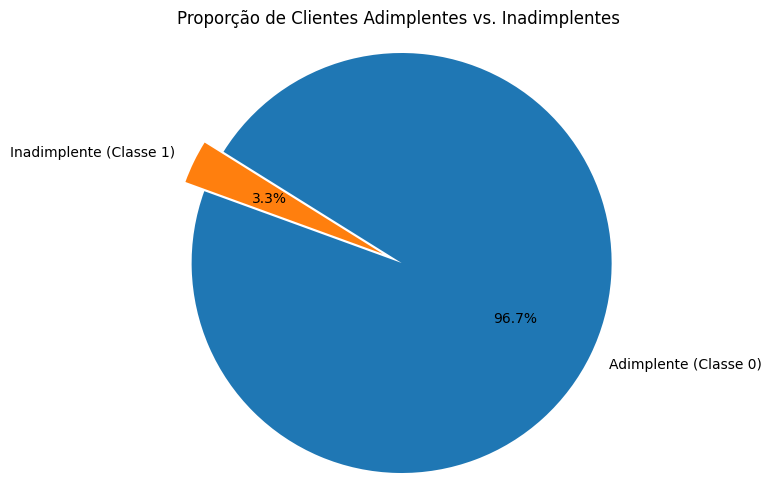

In [ ]:
# Gráfico de Pizza
counts = df['Defaulted?'].value_counts()
labels = ['Adimplente (Classe 0)', 'Inadimplente (Classe 1)']
explode = (0, 0.1)

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=160, explode=explode)

plt.title('Proporção de Clientes Adimplentes vs. Inadimplentes')
plt.axis('equal')
plt.show()

## 4. Definição do target, variáveis e divisão dos dados

In [ ]:
target = 'Defaulted?'

# Define as features (colunas de entrada), excluindo o target e o index
features = ['Employed', 'Bank Balance', 'Annual Salary']

print("Target:", target)
print("Features:", features)

X = df[features].copy()
y = df[target].copy()

# Divide os dados em treino e teste, mantendo a proporção das classes (estratificação)
# A variável SEED deve ter sido definida anteriormente (ex: SEED = 42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("\nFormato dos dados de Treino:", X_train.shape)
print("Formato dos dados de Teste:", X_test.shape)

Target: Defaulted?
Features: ['Employed', 'Bank Balance', 'Annual Salary']

Formato dos dados de Treino: (8000, 3)
Formato dos dados de Teste: (2000, 3)


## 5. Tratamento de dados e Pipeline de pré-processamento

In [ ]:
# --- Etapa 5: Pipeline de Pré-processamento ---

# Como todas as features são numéricas e não há dados faltantes,
# nosso pipeline precisa apenas padronizar os dados.
preprocess_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

print("Pipeline de pré-processamento criado com sucesso:")
print(preprocess_pipeline)

Pipeline de pré-processamento criado com sucesso:
Pipeline(steps=[('scaler', StandardScaler())])


## 6. Baseline e modelos candidatos

In [ ]:
models = []

# Adiciona o Baseline: Regressão Logística (LR)
models.append(('LR', Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('classifier', LogisticRegression(random_state=SEED))
])))

# Adiciona o Candidato 1: Árvore de Decisão (CART)
models.append(('CART', Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=SEED))
])))

# Adiciona o Candidato 2: Random Forest (RF)
models.append(('RF', Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('classifier', RandomForestClassifier(random_state=SEED))
])))

print("Modelos candidatos definidos com sucesso.")

Modelos candidatos definidos com sucesso.


## 6.1 Treino e avaliação rápida (baseline vs candidatos)

### 6.1.1 Escolhendo o Melhor Modelo do Jeito Certo

Para a comparação dos modelos (Regressão Logística, Árvore de Decisão e Random Forest), foi necessário adotar um método justo para medir o desempenho de cada um.

O problema é que uma única divisão dos dados em treino e teste pode levar a um resultado enviesado, dependendo da forma como os dados foram separados. Para evitar esse risco, foi utilizada a metodologia de Validação Cruzada Estratificada.

O processo funciona da seguinte forma:

O conjunto de treino é dividido em 10 partes.

O modelo é então treinado 10 vezes. Em cada rodada, 9 partes são usadas para o aprendizado e 1 parte é usada para o teste.

O desempenho final do modelo corresponde à média dos resultados obtidos nessas 10 rodadas.

Com isso, obtém-se uma visão muito mais estável e confiável da performance.

Um detalhe crucial é que foi usada a versão "Estratificada" porque o conjunto de dados é desbalanceado (apenas 3% de inadimplentes). Essa técnica garante que, em cada uma das 10 partes, a proporção original de 3% seja mantida, o que torna a avaliação mais precisa.

Dessa forma, a escolha do melhor modelo é feita com maior segurança, mantendo o conjunto de teste final (X_test) intacto para a avaliação definitiva ao final do projeto.

### 6.1.2 Validação dos modelos

Avaliação de Desempenho dos Modelos (via Validação Cruzada):

LR: 0.973500 (0.002291)
CART: 0.955750 (0.005483)
RF: 0.970375 (0.003214)




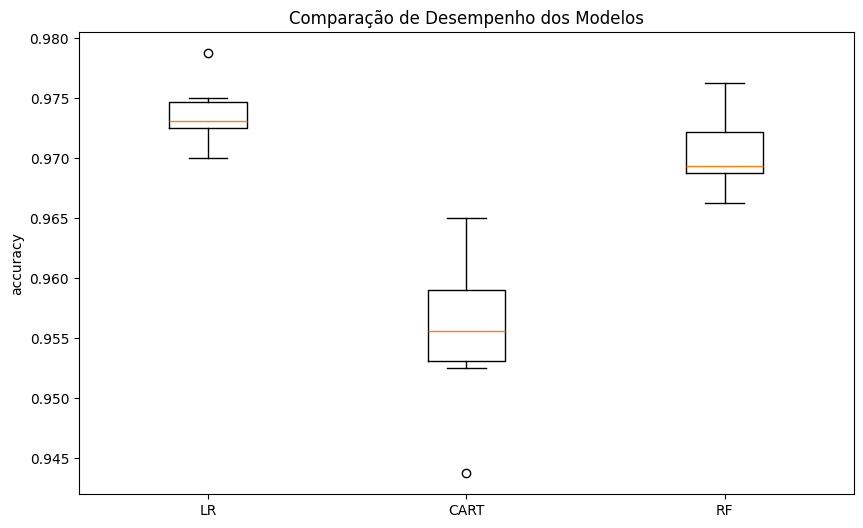

In [ ]:
# Foi utilizado StratifiedKFold para manter a proporção das classes em cada dobra.
num_particoes = 10
scoring = 'accuracy' # ou 'f1_weighted' se preferir
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=SEED)

results = []
names = []

print("Avaliação de Desempenho dos Modelos (via Validação Cruzada):\n")
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

print("\n")
plt.figure(figsize=(10, 6))
plt.title('Comparação de Desempenho dos Modelos')
plt.boxplot(results)
plt.xticks(ticks=[1, 2, 3], labels=names)
plt.ylabel(scoring)
plt.show()

## 7. Otimização de Hiperparâmetros

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 2. Define o pipeline do modelo que será otimizado (nosso campeão, o RF)
#    Note que usamos 'model' como o nome do passo do classificador.
model_to_tune = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('model', RandomForestClassifier(random_state=SEED))
])

# 3. Define as faixas de busca para os hiperparâmetros
#    A sintaxe 'model__<parametro>' informa qual passo do pipeline queremos otimizar.
param_dist = {
    "model__n_estimators": randint(100, 400),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10)
}

# 4. Define a métrica que queremos otimizar. 'f1_weighted' é uma boa escolha para dados desbalanceados.
scorer = "f1_weighted"

# 5. Configura e executa a busca aleatória (RandomizedSearchCV)
#    n_iter=10 significa que ele testará 10 combinações aleatórias.
search = RandomizedSearchCV(
    model_to_tune,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring=scorer,
    random_state=SEED,
    n_jobs=-1, # Usa todos os processadores disponíveis
    verbose=1  # Mostra o progresso do treinamento
)

# Inicia o processo de otimização
search.fit(X_train, y_train)

# 6. Exibe os resultados
print("\nOtimização concluída.")
print(f"Melhor score (CV F1-Weighted): {search.best_score_:.4f}")
print("Melhores parâmetros encontrados:", search.best_params_)

# O objeto 'search.best_estimator_' agora contém o pipeline completo com os melhores parâmetros
best_model_optimized = search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Otimização concluída.
Melhor score (CV F1-Weighted): 0.9679
Melhores parâmetros encontrados: {'model__max_depth': 5, 'model__min_samples_split': 7, 'model__n_estimators': 357}


## 8. Avaliação final, análise de erros e limitações

### 8.1 Avaliação do Baseline (LR):

--- Avaliação do Modelo Baseline (LR) no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1933
           1       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



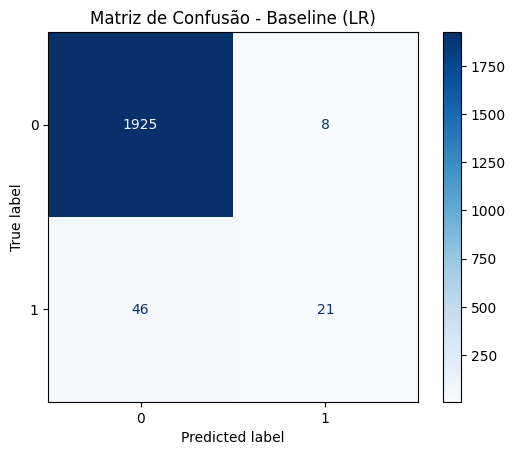

In [ ]:

print("--- Avaliação do Modelo Baseline (LR) no Conjunto de Teste ---")
# O primeiro modelo na nossa lista 'models' é o LR
baseline_model = models[0][1] # Pega o pipeline do LR
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

print(classification_report(y_test, y_pred_baseline))
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusão - Baseline (LR)")
plt.show()

### 8.2 Avaliação do Melhor Modelo Otimizado (RF):


--- Avaliação do Melhor Modelo Otimizado (RF) no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1933
           1       0.67      0.36      0.47        67

    accuracy                           0.97      2000
   macro avg       0.82      0.68      0.73      2000
weighted avg       0.97      0.97      0.97      2000



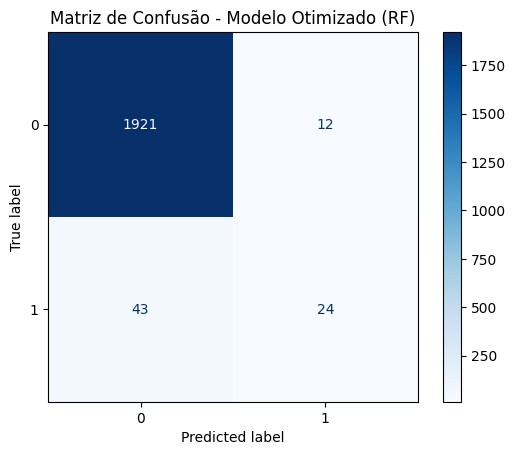

In [ ]:
print("\n--- Avaliação do Melhor Modelo Otimizado (RF) no Conjunto de Teste ---")
best_model_optimized = search.best_estimator_ # Este modelo já foi treinado pelo RandomizedSearchCV

# Como o best_model_optimized já foi treinado com os melhores parâmetros,
# podemos usá-lo diretamente para prever no conjunto de teste.
y_pred_optimized = best_model_optimized.predict(X_test)

print(classification_report(y_test, y_pred_optimized))
ConfusionMatrixDisplay.from_estimator(best_model_optimized, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusão - Modelo Otimizado (RF)")
plt.show()

### 8.3 - Avaliação do Modelo Otimizado e Balanceado


--- Avaliação do Modelo Otimizado e BALANCEADO (RF com class_weight) ---
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1933
           1       0.19      0.85      0.30        67

    accuracy                           0.87      2000
   macro avg       0.59      0.86      0.62      2000
weighted avg       0.97      0.87      0.91      2000



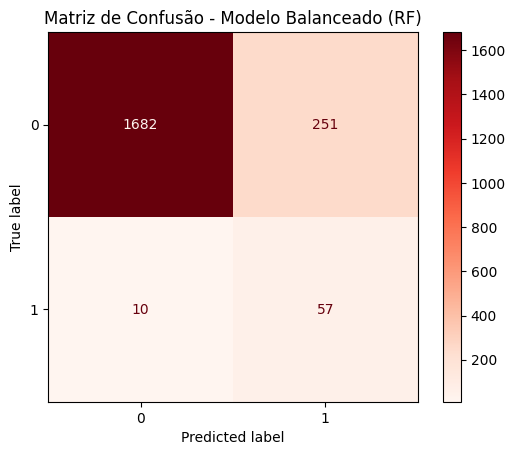

In [ ]:
print("\n--- Avaliação do Modelo Otimizado e BALANCEADO (RF com class_weight) ---")

# Pegamos o melhor pipeline encontrado e criamos uma nova versão com o class_weight ajustado.
# Usamos .set_params() para alterar o hiperparâmetro do passo 'model' dentro do pipeline.
balanced_model = search.best_estimator_
balanced_model.set_params(model__class_weight='balanced')

# Treinamos este novo modelo balanceado com os dados de treino
balanced_model.fit(X_train, y_train)

# Fazemos a previsão final no conjunto de teste
y_pred_balanced = balanced_model.predict(X_test)

# Exibimos os resultados
print(classification_report(y_test, y_pred_balanced))
ConfusionMatrixDisplay.from_estimator(balanced_model, X_test, y_test, cmap='Reds') # Usamos outra cor para diferenciar
plt.title("Matriz de Confusão - Modelo Balanceado (RF)")
plt.show()

A análise comparativa das matrizes de confusão do baseline e do modelo otimizado revela que ambos apresentam um desafio similar: uma baixa capacidade de identificar a classe minoritária, apesar da alta acurácia geral.

Ao utilizarmos a técnica de balanceamento, dando mais pesos para erros da classe minoriotária, o modelo melhora na identificação desse target, mas tem menor precisão geral.

## 9. Engenharia de atributos

Para este projeto, a engenharia de atributos consistiu em duas etapas principais:

Seleção de Atributos: Selecionamos as variáveis ['Employed', 'Bank Balance', 'Annual Salary'] como features preditivas. A coluna Index foi removida por não conter valor informacional para o modelo.

Padronização de Escala (StandardScaler): Como as features numéricas possuem escalas muito diferentes (Salário vs. Empregado), aplicamos a padronização para garantir que nenhuma variável domine o processo de treinamento indevidamente. Esta etapa foi encapsulada em um pipeline para evitar vazamento de dados.

## 10. Boas práticas e rastreabilidade

Ao longo do projeto, seguimos as seguintes boas práticas:

Baseline Claro: Utilizamos a Regressão Logística como um modelo baseline simples e interpretável para estabelecer um ponto de partida de performance.

Uso de Pipelines: Todas as etapas de pré-processamento e modelagem foram encapsuladas em pipelines do Scikit-learn. Isso garantiu a reprodutibilidade e, mais importante, evitou o vazamento de dados (data leakage) do conjunto de teste para o de treino.

Decisões Documentadas: Todas as decisões importantes, como a escolha da validação cruzada sobre a divisão simples para a seleção de modelos e a escolha do F1-score como métrica de otimização devido ao desbalanceamento de classes, foram documentadas e justificadas nas seções apropriadas.

## 11. Conclusões e próximos passos

O projeto apresenta um potencial de aprimoramento nos processos de uma empresa em início de operação ou considerada pequena, que não faça uso de modelos preditivos em seus processos, porém o modelo apresenta limitações com base na quantidade de atributos disponíveis, sendo necessário uma quantidade maior de variáveis para que possa ser obtido uma maior assertividade e de fato aplicado de forma profissional.

A discrepância entre classes leva a uma complexidade em lidar com uma base de poucos atributos, tornando mais difícil para o modelo ser preciso nas acusações da classe com baixa porcentagem de aparição. O modelo se torna enviesado pela discrepância e pode simplesmente "chutar" o "target" de maior aparição e ainda sim, acertar +95% das vezes, porém é aí que está a dificuldade do modelo, acertar as classes que representam menos de 5% do total.

A comparação final entre os 3 modelos revelou um trade-off entre a segurança financeira da empresa e a experiência do cliente.

Conclui-se que embora a metodologia de machine learning seja promissora, a escoha do modelo a ser implementado depende diretamente da estratégia de negócio da empresa ou ainda uma necessidade de análises mais complexas ou incremento de informações na própria base de dados para podermos garantir que ele funcione como esperado em uma possível generalização.

Para a evolução do projeto, é recomendado como ponto de partida:
> Utilizar dados reais: Visando garantir a generalização, o próximo passo é replicar o modelo utilizando o histórico de dados reais de financiamento de uma empresa, captando informações mais pessoais do que genéricas de um dataset público.

> Enriquecer a base de dados com novos atributos relevantes para análise de crédito, como por exemplo:
* Histórico de crédito do cliente
* Score do CPF
* Valor e modelo do veículo financiado
* Parcela pretendida

> Para melhorar a precisão na captura da classe minoritária, apesar da discrepância, pode-se utilizar técnicas como o ajuste de pesos do modelo (class_weight, testado no modelo) buscando um "meio-termo" ou a criação de dados sintéticos (ex: SMOTE).

## 12: Salvando Artefatos (Modelos e Pipeline)

In [ ]:
# Salva o pipeline completo em um arquivo .pkl
joblib.dump(best_model_optimized, 'modelo_financiamento_v1.pkl')

print("Modelo final salvo com sucesso em 'modelo_financiamento_v1.pkl'")

# Para carregar o modelo no futuro, você usaria:
#loaded_model = joblib.load('modelo_financiamento_v1.pkl')
#print("Modelo carregado com sucesso.")

Modelo final salvo com sucesso em 'modelo_financiamento_v1.pkl'
Modelo carregado com sucesso.
